# UMAP을 이용한 차원축소 및 HDBSCAN을 통한 군집화

In [1]:
#UMAP이 없다면 해당 라이브러리 설치 필수
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=2535046c589295bcf755828d089265dced3452e7610f59a4038ff9e709da8feb
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55621 sha256=6abb06e102362dbd79b0759b8df77e205b1a092e5db436668afe810d2f2a3619
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [2]:
#HDBSCAN이 없다면 해당 라이브러리 설치 필수
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 48.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039170 sha256=c7a8dd949645372569876e4deac53890a03e29174be8f2bf8f445f07fb59fa62
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [3]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import json
import torch
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
sns.set(style='white', context='notebook', rc={'figure.figsize':(10,10)})
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
#plt.rcParams['font.family'] = 'Malgun Gothic'

# 1. 임베딩 값 구하기

In [ ]:
# json file에서 query와 topic추출
'''
with open('/content/drive/MyDrive/topic_extraction/preprocessed.json') as f:
    json_data = json.load(f)

topic_list = []
for i in range(len(json_data)):
  topic_list.append(json_data[i]['topic'])

model = AutoModel.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'
tokenizer = AutoTokenizer.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'

# 임베딩값 얻기
def get_embeddings(text):
    inputs_output = tokenizer(text, max_length=32, padding='max_length', truncation=True, return_tensors='pt')
    embeddings_output, _ = model(**inputs_output, return_dict = False)
    average_embedding = torch.mean(embeddings_output, dim=1)
    result_embedding = average_embedding.tolist()[0]
    return result_embedding
'''

"\nwith open('/content/drive/MyDrive/topic_extraction/preprocessed.json') as f:\n    json_data = json.load(f)\n\ntopic_list = []\nfor i in range(len(json_data)):\n  topic_list.append(json_data[i]['topic'])\n\nmodel = AutoModel.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'\ntokenizer = AutoTokenizer.from_pretrained('BM-K/KoSimCSE-roberta-multitask')  # or 'BM-K/KoSimCSE-bert-multitask'\n\n# 임베딩값 얻기\ndef get_embeddings(text):\n    inputs_output = tokenizer(text, max_length=32, padding='max_length', truncation=True, return_tensors='pt')\n    embeddings_output, _ = model(**inputs_output, return_dict = False)\n    average_embedding = torch.mean(embeddings_output, dim=1)\n    result_embedding = average_embedding.tolist()[0]\n    return result_embedding\n"

In [ ]:
'''
embed_list = []
print('딥러닝 모델을 활용한 임베딩: ')
for t in tqdm(topic_list):
  embed_list.append(get_embeddings(t))

# topic과 이에 대한 kosimCSE 임베딩값으로 구성된 데이터프레임 출력
embed_df = pd.DataFrame(embed_list, index=topic_list, columns=range(768))
'''

"\nembed_list = []\nprint('딥러닝 모델을 활용한 임베딩: ')\nfor t in tqdm(topic_list):\n  embed_list.append(get_embeddings(t))\n\n# topic과 이에 대한 kosimCSE 임베딩값으로 구성된 데이터프레임 출력\nembed_df = pd.DataFrame(embed_list, index=topic_list, columns=range(768))\n"

In [ ]:
embed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
네트워크 보안의 중요성,0.116927,0.681634,-0.152465,-1.229325,-0.207835,-0.178415,-0.246346,-0.155677,0.533144,-1.019329,...,-0.320203,-0.097273,0.379036,0.216836,-0.191186,-0.645657,0.115158,0.553351,-0.129278,0.094014
구의 표면적 계산,-0.261555,-0.544070,0.029593,-0.322764,0.089181,-0.231930,0.614833,-0.381301,-0.172060,0.315409,...,0.316477,0.682708,0.796344,-0.225745,-0.396274,-0.571863,0.148959,0.091683,0.007381,-0.248934
Javascript 함수 코딩,-0.672415,-0.110136,0.128165,-0.043420,-0.596236,-0.454626,-0.107101,0.225913,-0.572920,-0.086770,...,-0.089989,-0.008676,0.172871,-0.389015,-0.641723,-0.523898,-0.311032,0.635408,0.123138,-0.615767
시간 관리 방법,-0.550109,0.209159,-0.302087,-0.359368,-0.127091,0.039304,0.669858,-0.284321,-0.321336,0.210889,...,0.099965,0.925298,0.084155,-0.058149,-0.559757,0.111023,-0.196493,-0.590139,-0.683530,-0.094504
메시지 최적화,-0.086890,0.136155,-0.426490,-0.040805,-0.142248,-0.189675,0.226427,0.316790,-0.385984,0.635227,...,-0.146914,0.095318,0.431561,0.451820,-0.157010,-0.526070,-0.665980,-0.141982,0.295224,-0.062536


# 2. UMAP을 이용한 차원축소

## UMAP
toplogical 데이터 분석으로 manifold learning기술을 기반으로 한 차원 축소 알고리즘
t-SNE, PCA 보다 카테고리 간 분리가 명확하게 되어있으며 빠른 시간에 차원을 축소할 수 있음. 두 가지 주요한 파라미터를 사용:

credits: [https://m.blog.naver.com/myohyun/222421460444](https://m.blog.naver.com/myohyun/222421460444)

**1) n_neighbors:**<br>
초기 고차원 그래프 생성 시에 사용되는 nearest neighbor의 숫자로 가장 중요한 파라미터임
n_neighbors의 수가 작으면 : local stracture에 집중
n_neighbors의 수가 크면 : global stracture에 집중

**2) min_dist:**<br>
저차원 공간에서 포인트간의 최소 거리
umap이 얼마나 촘촘히 데이터를 묶을건지를 조절
min_dist값이 작으면: 포인트들이 촘촘하게 무리지어있게 됨
min_dist값이 크면: 포인트들이 상대적으로 느슨하게 퍼져있게 됨
n_neighbors가 커질수록 고차원 그래프에서 이웃한 데이터포인트간의 연결을 늘려 데이터의 전체적인 군집을 훨씬 더 정확하게 반영할 수 있음
min_dist값이 커지면 클러스터링을 약화시키고 global structure를 덜 강조함

**3)n_components:**<br>
줄여서 결과값으로 나오는 차원. 꼭 2차원이 아니어도 됨

In [6]:
embed_df = pd.read_csv('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/embedding_df.csv', index_col = 0)

In [7]:
len(embed_df)

95983

In [8]:
# 중복제거
embed_df = embed_df.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [9]:
len(embed_df)

86825

In [10]:
topic_list = embed_df.index.tolist()

In [11]:
topic_list[:3]

['네트워크 보안의 중요성', '구의 표면적 계산', 'Javascript 함수 코딩']

In [12]:
sum(embed_df.isnull().sum())

0

In [14]:
### default setting:
#n_neighbors: float (optional, default 15)
#min_dist: float (optional, default 0.1)
#n_components: int (optional, default 2)
def umap_reducer(neighbors, min_distance, reduce_dim, data):
  print('UMAP을 통한 차원축소를 시작합니다...')
  reducer = umap.UMAP(low_memory = False, n_neighbors=neighbors, min_dist = min_distance, n_components = reduce_dim, random_state = 42)
  embedding = reducer.fit_transform(data)
  topic_list = data.index.tolist()
  # 데이터프레임 형태로 변환
  embedding_df = pd.DataFrame(embedding, index = topic_list)
  embedding_df.to_csv('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/umap_reduce_result_53.csv', encoding = 'utf-8-sig')
  # 시각화
  plt.scatter(embedding.T[0], embedding.T[1], color='b')
  plt.legend(loc = 2, bbox_to_anchor = (1,1))
  plt.savefig('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/umap_result_53.png')
  plt.show()
  return embedding_df

UMAP을 통한 차원축소를 시작합니다...


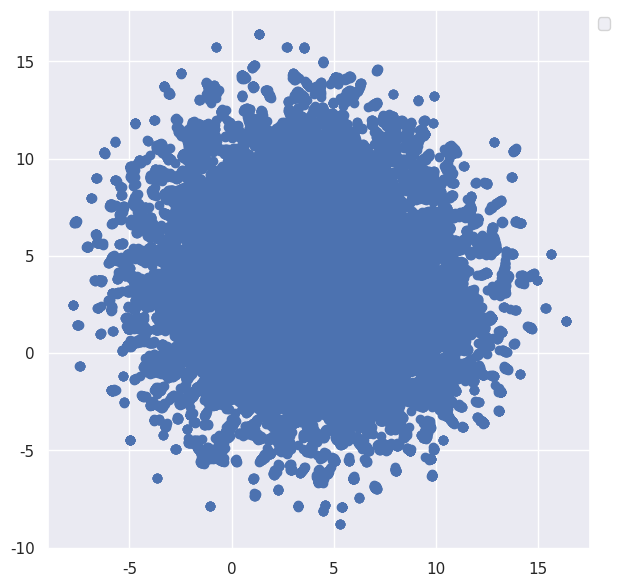

In [44]:
umap_df = umap_reducer(neighbors = 5, min_distance = 0.3, reduce_dim = 2, data = embed_df)

In [45]:
print(f'원본데이터 수: {embed_df.shape}')
print(f'차원축소한 데이터 수: {umap_df.shape}')

원본데이터 수: (86825, 768)
차원축소한 데이터 수: (86825, 2)


# 3. hdbscan을 통한 클러스터링 수행
dbscan + 계층적 클러스터링을 합한 개념
주요 하이퍼파라미터

credit: [https://hdbscan.readthedocs.io/en/latest/parameter_selection.html](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)

**1)min_cluster_size**:<br>
하나의 군집에 최소로 들어갈 data 수

**2)min_samples**:<br>
The larger the value of `min_samples`you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

**3)cluster_selection_epsilon**:<br>
ensures that clusters below the given threshold are not split up any further. The choice of `cluster_selection_epsilon`depends on the given distances between your data points. For example, set the value to 0.5 if you don’t want to separate clusters that are less than 0.5 units apart.

### HDBSCAN의 default value
default values:<br>
HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=False, leaf_size=40, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None)
    
#### <b>여러실험 결과 최적의 파라미터값을 찾아내어 군집화 수행</b> ####

In [37]:
def hdbscan_cluster(min_size, min_sample, cluster_distance, data):
  print('hdbscan을 활용한 군집화를 시작합니다...')
  hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_size, min_samples = min_sample, cluster_selection_epsilon = cluster_distance, approx_min_span_tree=True)
  hdbscan_model.fit(data)
  hdbscan_labels = list(hdbscan_model.labels_)
  print(f'총 군집의 개수: {hdbscan_model.labels_.max()+2}')
  data['hdbscan_label'] = hdbscan_model.labels_
  data['hdbscan_label'] = data['hdbscan_label'].astype(str)
  data.rename(columns = {0: 'x', 1:'y'}, inplace = True)
  data.to_csv('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/hdbscan_result_535.csv', encoding = 'utf-8-sig')
  sns.set(rc={'figure.figsize':(7,7)})
  ax = sns.scatterplot(x = 'x', y = 'y', hue = 'hdbscan_label', data = data, legend = False)
  plt.savefig('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/hdbscan_scatter_535.png')
  plt.show()
  return data

hdbscan을 활용한 군집화를 시작합니다...
총 군집의 개수: 15279


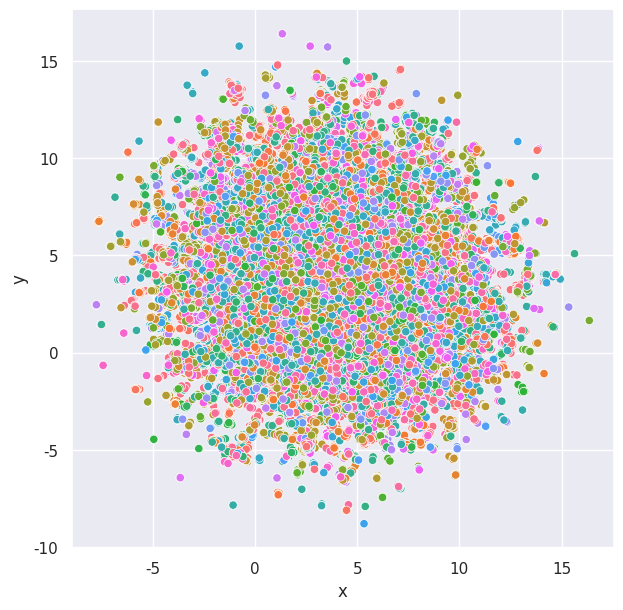

In [38]:
fin_df = hdbscan_cluster(min_size = 2, min_sample = None, cluster_distance = 0.05, data = umap_df)

In [52]:
# 군집번호를 입력하면 해당 군집에 속해있는 데이터 출력
cond = fin_df['hdbscan_label'] == '1100'
da[cond].index

Index(['추수감사절 요일', '맥도날드 제품 및 업적', '추수감사절 의미', '추수감사절 저녁 식사 메뉴', '추수감사절 음식 종류',
       '미국 추수감사절 음식 준비', '추수감사절 요리 제안', '레스토랑의 신메뉴 개발', '레스토랑 대화 생성'],
      dtype='object')

In [41]:
len(fin_df[cond].index)

900

In [48]:
da = pd.read_csv('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/hdbscan_result_5.csv', index_col = 0)
len(da[cond].index)

900

**평가지표: Silhouette Score**

다른 클러스터(**seperation**)에 비해 자신의 클러스터(**cohesion**)와 얼마나 유사한 지 측정합니다. 실루엣 범위는 -1에서 +1까지이며, **값이 높으면 객체가 자체 클러스터와 잘 일치하고 인접 클러스터와 잘 일치하지 않음을 나타냅니다**. **대부분의 개체에 높은 값이 있으면 클러스터링 구성이 적합합니다. 0.25이상이면 됨**

In [42]:
# 모든 개별 데이터에 실루엣 계수값 구해 군집별 평균 실루엣계수 구하기
# 실루엣 계수값 바탕으로 어느 군집 제거할 것인지 판단

def cal_sihouette_score(data):
  X=data.iloc[:,:-1]
  labels=data.iloc[:,-1]
  score_samples=silhouette_samples(X, labels)
  data['silhouette_coeff']=score_samples
  #num_cluster = data.groupby('hdbscan_label')['silhouette_coeff'].count()
  cluster_scores = data.groupby('hdbscan_label')['silhouette_coeff'].mean()
  cluster_below = cluster_scores[cluster_scores < 0.25].index
  data_filtered = data[~data['hdbscan_label'].isin(cluster_below)]

  print(f'"군집별 실루엣 스코어 평균: {cluster_scores.head()}\n')
  print(f"실루엣 스코어가 0.25 미만인 군집 개수: {len(cluster_below)}\n")
  print(f"필터링 후 살아남은 데이터의 수: {len(data_filtered)}")
  return data_filtered

In [49]:
dd = cal_sihouette_score(da)

"군집별 실루엣 스코어 평균: hdbscan_label
-1   -0.990876
 0    0.999953
 1    0.999931
 2    0.987059
 3    0.999923
Name: silhouette_coeff, dtype: float64

실루엣 스코어가 0.25 미만인 군집 개수: 684

필터링 후 살아남은 데이터의 수: 60129


In [34]:
print(f'미달 데이터의 수: {86825 - len(dd)}')

살아남은 데이터의 수: 55054


In [53]:
dd.head()

,x,y,hdbscan_label,silhouette_coeff
네트워크 보안의 중요성,8.146051,3.800064,6626,0.639353
Javascript 함수 코딩,7.431453,-3.376506,810,-0.020346
시간 관리 방법,3.769618,7.098816,6030,0.525335
도움 요청,3.472782,1.800682,7151,0.499423
분류할 수 없음,2.022592,-1.481394,5457,0.650310


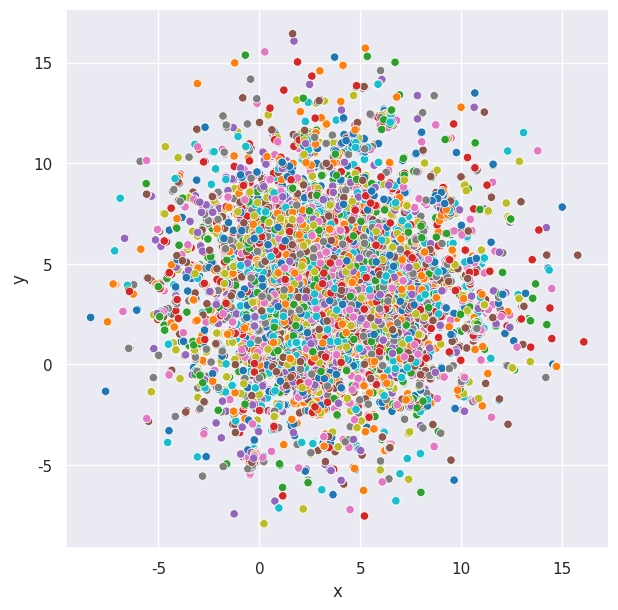

In [56]:
  import seaborn as sns
  sns.set(rc={'figure.figsize':(7,7)})
  ax = sns.scatterplot(x = 'x', y = 'y', hue = 'hdbscan_label', data = dd, legend = False, palette = 'tab10')
  #plt.savefig('/content/drive/MyDrive/topic_extraction/umap_hdbscan/output/hdbscan_scatter_filtered.png')
  plt.show()

In [55]:
cluster_scores = dd.groupby('hdbscan_label')['silhouette_coeff'].mean()
cluster_scores

hdbscan_label
0        0.999953
1        0.999931
2        0.987059
3        0.999923
4        0.999719
           ...   
11015    0.659784
11016    0.347083
11017    0.519116
11018    0.703203
11020    0.293167
Name: silhouette_coeff, Length: 10338, dtype: float64

In [61]:
cluster_num = dd.groupby('hdbscan_label')['silhouette_coeff'].count() # 필터링 된 군집의 평균 데이터 수
np.mean(cluster_num) #5.81개

5.816308763784098

In [60]:
cond = fin_df['hdbscan_label'] == '2'
dd[cond].index

<ipython-input-60-8c731b5a234e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dd[cond].index


Index(['거북이 음식', '애완용 거북이 키우기의 문제점', '거북이 이야기 쓰기', '거북이의 생태계 기능', '거북이와 차이점',
       '애완용 거북이 이야기', '거북이와 개구리의 생활환경 설명', '거북이 재미있는 사실', '거북이에 관한 창작시',
       '애완 거북이 사는 이유 설명 편지'],
      dtype='object')